# FIN30200: Econometrics of Financial Markets
Group Project - Modeling Exchange Rate Volatility: Application of the GARCH and EGARCH Models 

Ciaran Maxwell: 

Conor Gallagher:

Liam Holland:

Mark Mullins:

Odhran Murphy: 19469442

## Import Libraries

In [1]:
# Import the standard data analysis libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Time Series Analysis Library: AR,VAR,ARMA; ACF&PACF
import statsmodels.tsa as tsa

# Regression and Regression Test Libraries
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Import acf & pacf plotting functions 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting library
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import seaborn as sns

# Calling Python magic command
%matplotlib inline
# Adjust the figure size
matplotlib.rcParams['figure.figsize']=[10,6]

# Module to use
import os

# Import ARCH
from arch import arch_model

# Import ADF and PP unit root tests
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron as PP

# Import Shapiro-Wilk test
from scipy.stats import shapiro as sw

# Ljung-Box test function
from statsmodels.stats.diagnostic import acorr_ljungbox

## Set GitHub Repository

In [2]:
base_url = 'https://raw.githubusercontent.com/odhran-murphy/EFM_Group_Project/main' 

## Common Plotting Functions

#### `plot_series`

In [3]:
def plot_series(series, title, ylabel):
    """Plot the series against the time index of dataframe."""
    
    plt.plot(series)    
    plt.xlabel('Date') 
    plt.ylabel(ylabel) 
    plt.title(title) 
    plt.show()

#### `plot_acf_pacf`

In [4]:
def plot_acf_pacf(series, title):
    """Display both acf and pacf using a shared x-axis."""  
    
    fig, axes = plt.subplots(nrows=2, figsize=(10, 6))

    plot_acf(series, lags=40,ax=axes[0]) 
    plot_pacf(series, lags=40,ax=axes[1], method='ywm')
    plt.suptitle(title)
    plt.show()

#### `plot_series_v_normal`

In [5]:
def plot_series_v_normal(series, series_label, title):
    """Plot series histogram v normal distribution"""  
    
    # Applying the seaborn distplot function to get histogram & density curve of series 
    sns.histplot(series, kde=True, color='darkblue', stat='density', label = series_label)

    # Normal distribution with the same mean & variance
    np.random.seed(0) # Fixed seed to use

    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(series), np.std(series), 249)

    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color='red', shade=True, label = "Normal")
    
    plt.title(title)
    plt.legend()
    plt.show()

## Data Processing
This paper uses both GARCH (1,1) and EGARCH (1,1) to model the volatility of TZS/USD exchange rate for the January 4, 2009 - July 27, 2015 period.

In [6]:
filename = 'USD_TZS_Historical_Data.csv'
ex_rate_df = pd.read_csv(f'{base_url}/{filename}') # TZS to 1 USD rate
display(ex_rate_df)
ex_rate_df.info()

,Date,Price,Open,High,Low,Vol.,Change %
0,07/27/2015,"2,083.00","2,075.00","2,083.00","2,075.00",NaN,0.39%
1,07/24/2015,"2,075.00","2,075.00","2,077.00","2,075.00",NaN,0.00%
2,07/23/2015,"2,075.00","2,085.00","2,085.00","2,065.00",NaN,-1.89%
3,07/22/2015,"2,115.00","2,135.00","2,135.00","2,113.00",NaN,-0.94%
4,07/21/2015,"2,135.00","2,145.00","2,145.00","2,133.00",NaN,-0.47%
...,...,...,...,...,...,...,...
1706,01/09/2009,"1,357.00","1,341.00","1,360.00","1,325.00",NaN,1.04%
1707,01/08/2009,"1,343.00","1,330.00","1,343.00","1,325.00",NaN,0.30%
1708,01/07/2009,"1,339.00","1,335.00","1,340.00","1,335.00",NaN,-0.07%
1709,01/06/2009,"1,340.00","1,315.00","1,340.00","1,315.00",NaN,1.13%


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1711 non-null   object 
 1   Price     1711 non-null   object 
 2   Open      1711 non-null   object 
 3   High      1711 non-null   object 
 4   Low       1711 non-null   object 
 5   Vol.      0 non-null      float64
 6   Change %  1711 non-null   object 
dtypes: float64(1), object(6)
memory usage: 93.7+ KB


# NB
as per paper = 1593 daily observations ?

In [7]:
ex_rate_df = ex_rate_df[['Date', 'Price']] # Isolate USD to TZS exchange rate

# Rename Price column
ex_rate_df.columns.values[1] = 'TZS/USD'

# Convert from object to float - object contains a comma so needs to be split before conversion
ex_rate_df['TZS/USD'] = ex_rate_df['TZS/USD'].apply(lambda x: float(x.split()[0].replace(',', '')))

# Convert date from object to datetime
ex_rate_df['Date'] = pd.to_datetime(ex_rate_df['Date'],format = '%m/%d/%Y') 
ex_rate_df.set_index('Date',inplace=True) # Set date as index

display(ex_rate_df)

,TZS/USD
Date,
2015-07-27,2083.0
2015-07-24,2075.0
2015-07-23,2075.0
2015-07-22,2115.0
2015-07-21,2135.0
...,...
2009-01-09,1357.0
2009-01-08,1343.0
2009-01-07,1339.0


In [8]:
# Check number of missing values
ex_rate_df['TZS/USD'].isna().sum()

0

__Log Price Transformation__
$$r_{t} = \log_{10}(\frac{E_{t}}{E_{t-1}})=\log_{10}(E_{t})-\log_{10}(E_{t-1})$$

where

$r_{t}$ is the log price at time t

$E_{t}$ is the TZS/USD exchange rate at time t


# NB
Check whether natural log or log to base 10. Paper does not specify. Also do I take difference

In [9]:
# Apply transformation - check whether natural log or log to base 10 
ex_rate_df['log_TZS/USD'] = np.log10(ex_rate_df['TZS/USD'])
# Drop the missing values created by function
ex_rate_df.dropna(inplace=True) 
ex_rate_df['log_TZS/USD']
ex_rate_df

,TZS/USD,log_TZS/USD
Date,,
2015-07-27,2083.0,3.318689
2015-07-24,2075.0,3.317018
2015-07-23,2075.0,3.317018
2015-07-22,2115.0,3.325310
2015-07-21,2135.0,3.329398
...,...,...
2009-01-09,1357.0,3.132580
2009-01-08,1343.0,3.128076
2009-01-07,1339.0,3.126781


##  Stylized Facts (Exploratory Data Analysis)

### Clustering Volatility and Leverage Effects

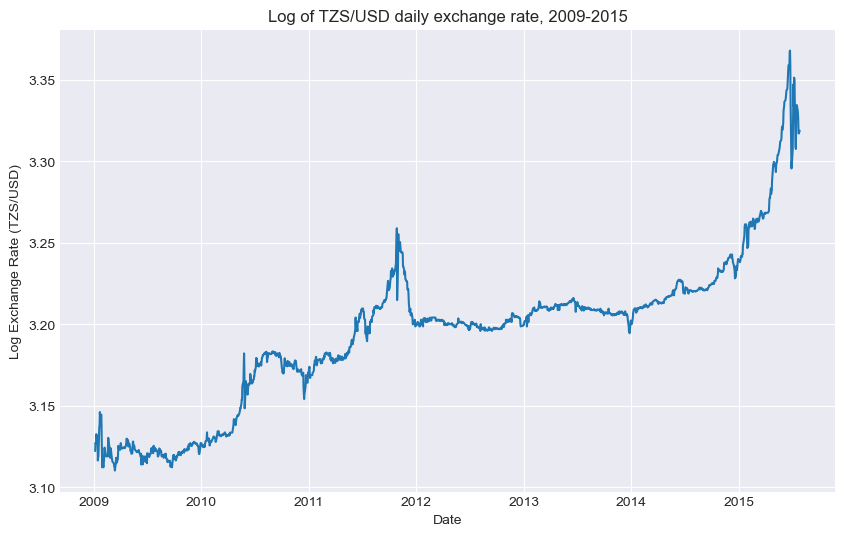

In [10]:
# Plot Log Exchange Rate (TZS/USD)
plot_series(ex_rate_df['log_TZS/USD'], 'Log of TZS/USD daily exchange rate, 2009-2015', 'Log Exchange Rate (TZS/USD)')

## Seems to work with log10 and no difference transformation

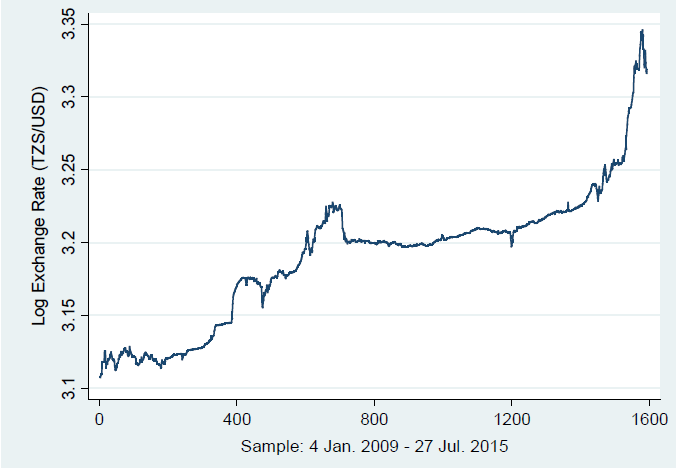

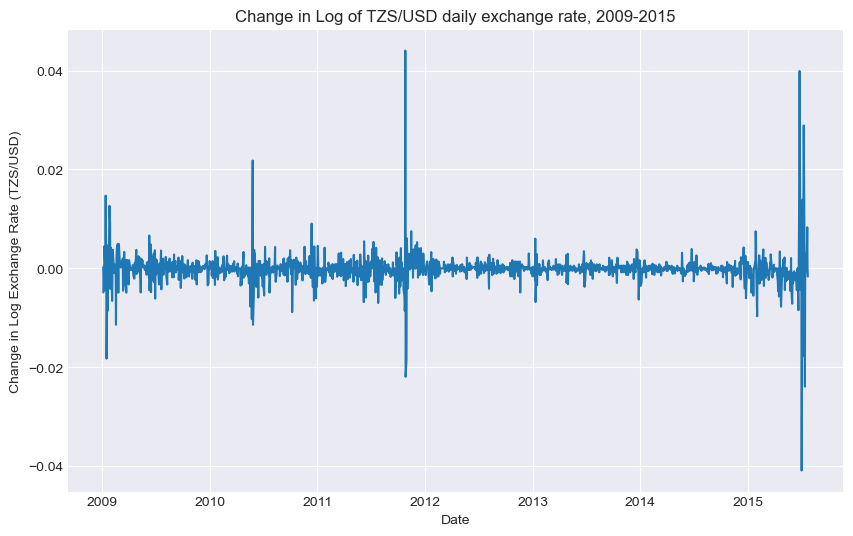

In [11]:
# Plot Change in Log Exchange Rate (TZS/USD)
plot_series(ex_rate_df['log_TZS/USD'].diff(), 'Change in Log of TZS/USD daily exchange rate, 2009-2015', 
            'Change in Log Exchange Rate (TZS/USD)')

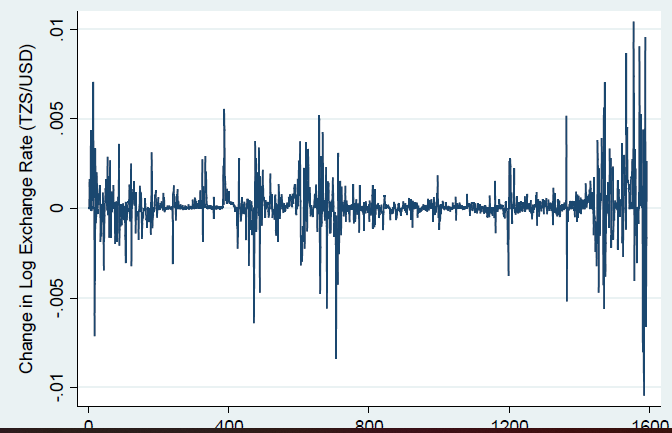

# NB
Scale is off

### Non-Normality Distribution of Fat Tails

In [12]:
# Jarque-Bera (JB) test
from scipy import stats
jarque_bera_test = stats.jarque_bera(ex_rate_df['log_TZS/USD'])
skewness = ex_rate_df['log_TZS/USD'].skew()
kurtosis = ex_rate_df['log_TZS/USD'].kurtosis()

print(jarque_bera_test, '\n', f'Skewness: {skewness}', '\n', f'Kurtosis: {kurtosis}')

Jarque_beraResult(statistic=109.73007436603635, pvalue=0.0) 
 Skewness: 0.3859410491644364 
 Kurtosis: 0.9781702553243412


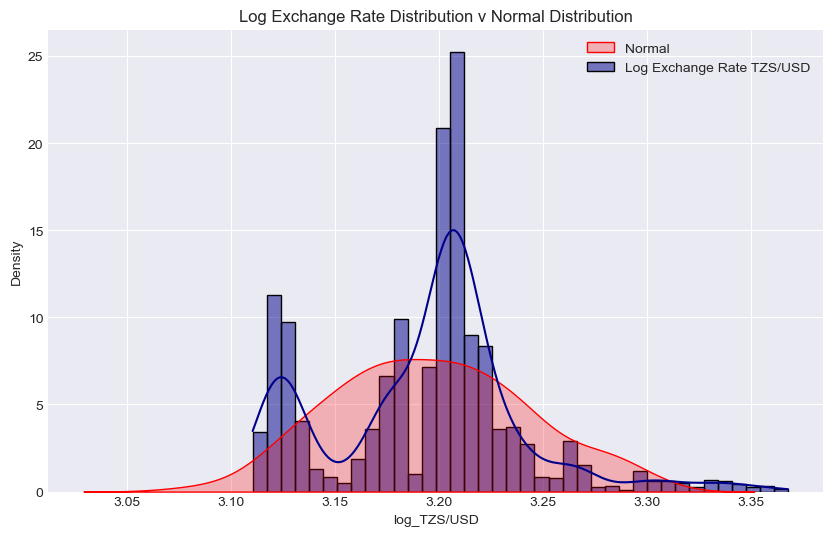

In [13]:
# Log Exchange Rate Distribution v Gaussian Distribution plot 
plot_series_v_normal(ex_rate_df['log_TZS/USD'], 'Log Exchange Rate TZS/USD', 
                     'Log Exchange Rate Distribution v Normal Distribution')

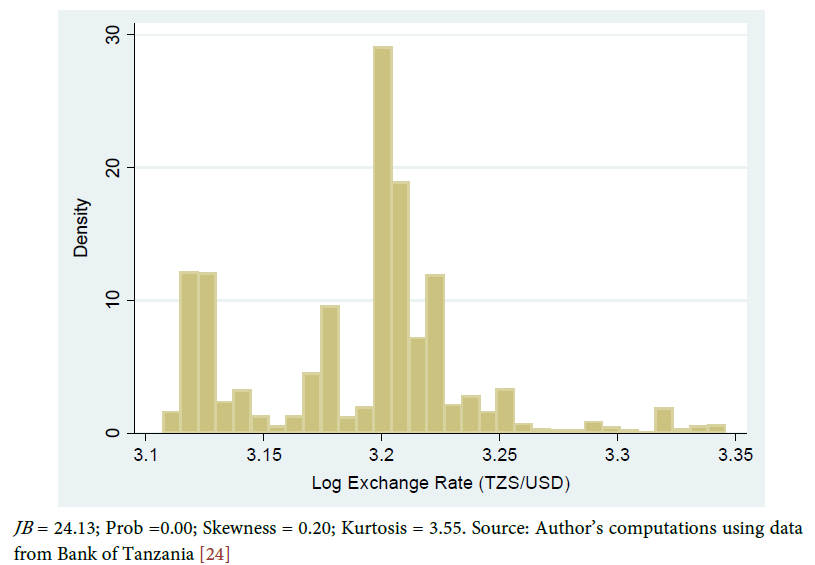

Does not match

__QQ-Plot: An assessment for data normality__
A QQ-Plot is used to visually determine how close a sample is to a specified distribution
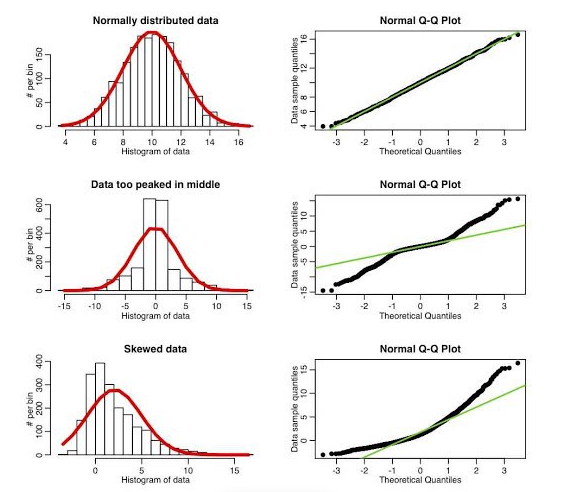

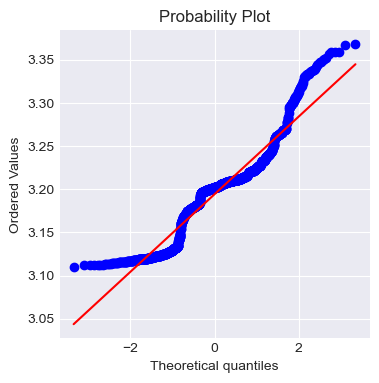

In [35]:
#QQ plot - addition -  nice to have
from scipy import stats
fig, (ax) = plt.subplots(figsize = (4,4))
res = stats.probplot(ex_rate_df['log_TZS/USD'],dist='norm', plot=ax)

# Combine into plot_series_v_normal with qq_plot = True as an argument

### Serial Correlation and Unit Root

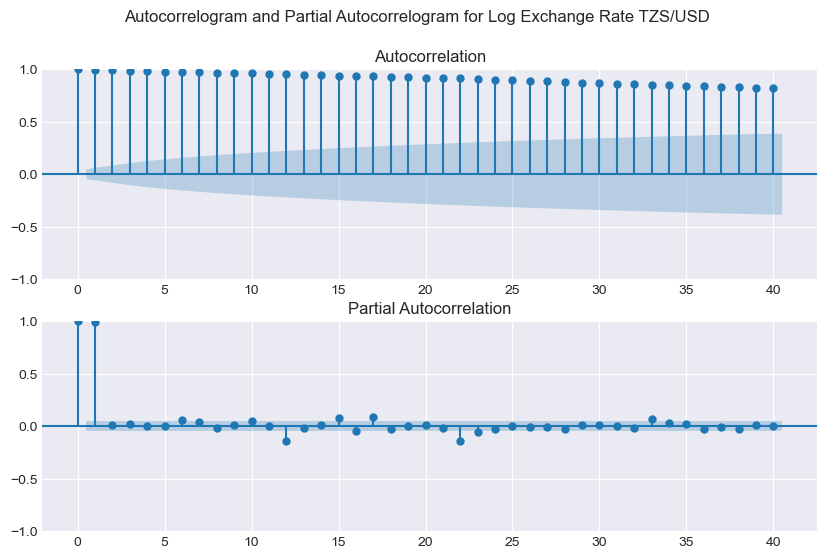

In [15]:
# Autocorrelogram and partial autocorrelogram (with 40 lags) plot
plot_acf_pacf(ex_rate_df['log_TZS/USD'], 'Autocorrelogram and Partial Autocorrelogram for Log Exchange Rate TZS/USD')

In [16]:
# ADF and PP unit root tests for stationarity code

adf_level = ADF(ex_rate_df['log_TZS/USD'], lags=40)
print(adf_level.summary())

pp_level = PP(ex_rate_df['log_TZS/USD'], lags=40)
print(pp_level.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.578
P-value                         0.098
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.192
P-value                         0.209
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [17]:
# ADF and PP unit root tests for stationarity in first difference code

log_ex_rate_diff = ex_rate_df['log_TZS/USD'].diff() # Take the first difference
log_ex_rate_diff.dropna(inplace=True) # Drop NA

adf_diff = ADF(log_ex_rate_diff, lags=40)
print(adf_diff.summary())

pp_diff = PP(log_ex_rate_diff, lags=40)
print(pp_diff.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.786
P-value                         0.000
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.237
P-value                         0.000
Lags                               40
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Parametric Volatility Models & Empirical Results
In this paper both GARCH (1,1) and EGARCH (1,1) are used to model the volatility of TZS/USD exchange rate for the January 4, 2009 - July 27, 2015 period.

Before estimating the ARCH and GARCH models, the paper investigates the exchange rate series in order to identify its statistical properties and to see if it meets the pre-conditions for the ARCH and GARCH models, that is, clustering volatility and ARCH effect in the residuals

### The ARCH Effect 
Test for the presence of ARCH effect is performed by first applying the least squares (LS) method in order to generate regression residuals. Then the ARCH heteroskedasticity test is applied to the residuals to ascertain whether time varying volatility clustering does exist.

In [18]:
# ARCH effect test using Least Square method

mean = ex_rate_df['log_TZS/USD'].mean()
log_ex_rate = ex_rate_df['log_TZS/USD']

# Fit a model
arch_effect_ols = smf.ols(formula='log_ex_rate ~ 1',data=ex_rate_df).fit() 
print(arch_effect_ols.summary())
print(f'Mean: {mean}')

                            OLS Regression Results                            
Dep. Variable:            log_ex_rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 23 Nov 2022   Prob (F-statistic):                nan
Time:                        17:47:54   Log-Likelihood:                 2817.0
No. Observations:                1711   AIC:                            -5632.
Df Residuals:                    1710   BIC:                            -5626.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1942      0.001   2832.114      0.0

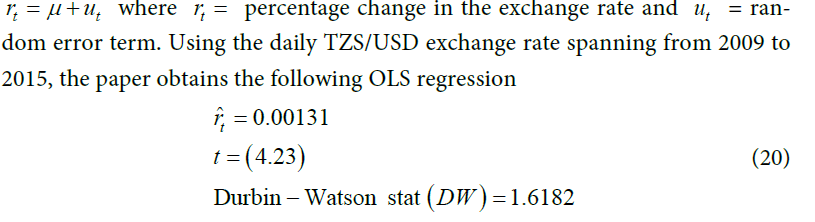

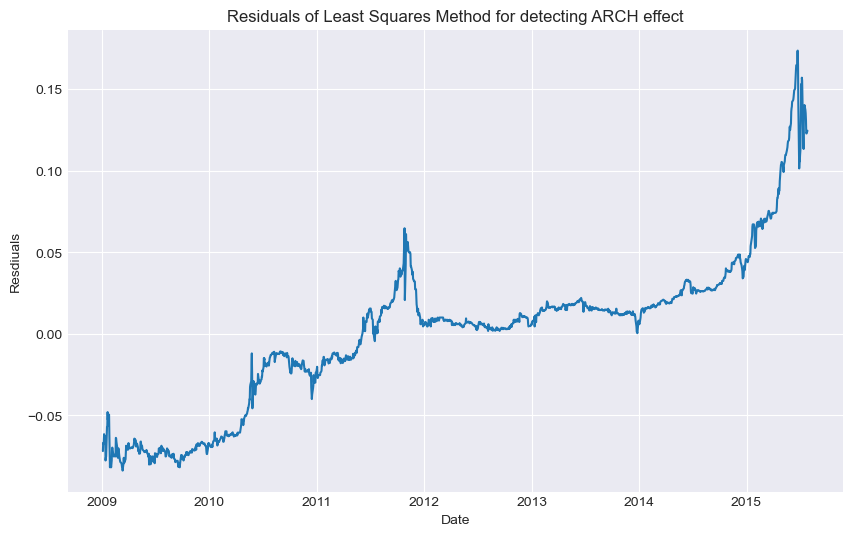

In [19]:
plot_series(arch_effect_ols.resid, 'Residuals of Least Squares Method for detecting ARCH effect', ylabel='Resdiuals')

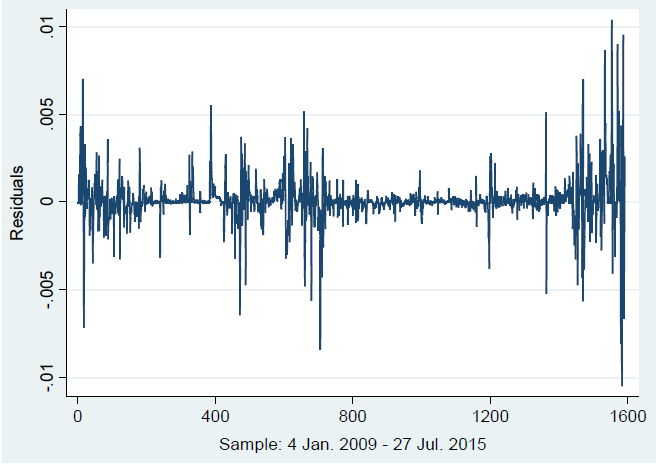

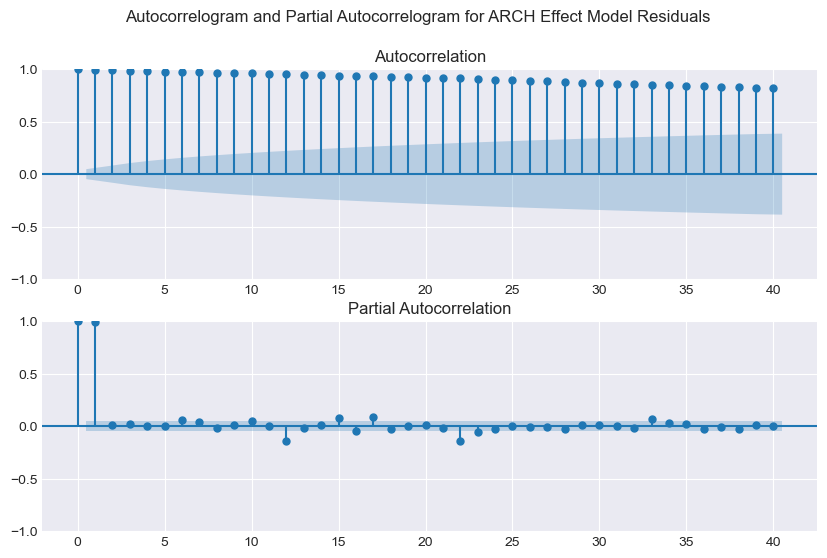

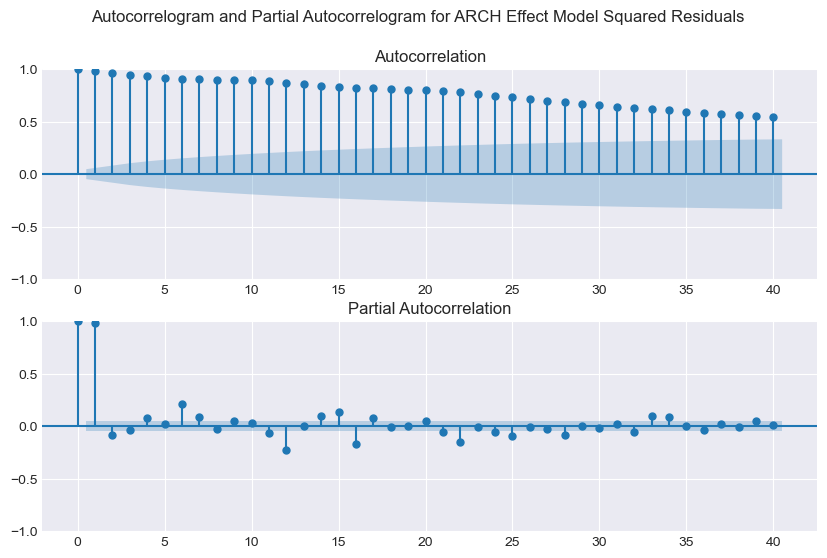

In [20]:
# Optional (from tutoriaL)
# Residuals correlation: No serial correlation for residuals from the model（assumption)
# Positive correlations found for squared residuals: one way to detect ARCH effect

plot_acf_pacf(arch_effect_ols.resid, 'Autocorrelogram and Partial Autocorrelogram for ARCH Effect Model Residuals')
plot_acf_pacf(np.square(arch_effect_ols.resid), 'Autocorrelogram and Partial Autocorrelogram for ARCH Effect Model Squared Residuals')

__Testing for ARCH Effect: Engle’s Test for Autoregressive Conditional Heteroscedasticity__

H0: There is no conditional heteroscedasticity/ No ARCH effect is present

H1: There is conditional heteroscedasticity/ ARCH effect is present

In [21]:
# ARCH LM test (Engle's Test) for autoregressive conditional heteroskedasticity (ARCH)

engle_test_data = sm.stats.diagnostic.het_arch(arch_effect_ols.resid)
engle_test_df = pd.DataFrame(engle_test_data)
engle_test_df.columns = ['Engle Test']
engle_test_df = engle_test_df.T
engle_test_df.columns = ['Lagrange Multiplier Test Statistic', 'LM p-value', 'F-statistic', 'F p-value']
display(engle_test_df)

,Lagrange Multiplier Test Statistic,LM p-value,F-statistic,F p-value
Engle Test,1668.901603,0.0,8786.867884,0.0


In [22]:
# From tutorial - ARCH(1)
arch_effect = arch_model(ex_rate_df['log_TZS/USD'], vol='ARCH', p=1, q=0, rescale=False).fit()
print(arch_effect.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.662973533495164e+21
Iteration:      2,   Func. Count:     19,   Neg. LLF: 669309663.6944218
Iteration:      3,   Func. Count:     31,   Neg. LLF: 66252.95236525948
Iteration:      4,   Func. Count:     42,   Neg. LLF: 844197802543.5573
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1508.7629913687435
Iteration:      6,   Func. Count:     60,   Neg. LLF: 148726642.36069396
Iteration:      7,   Func. Count:     70,   Neg. LLF: 730.2112234597719
Iteration:      8,   Func. Count:     75,   Neg. LLF: 23484991.020823617
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5.151477489305799e+18
Iteration:     10,   Func. Count:     92,   Neg. LLF: 25841.80718134514
Iteration:     11,   Func. Count:    102,   Neg. LLF: 5151641690108016.0
Iteration:     12,   Func. Count:    110,   Neg. LLF: -2250.718194974811
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2250.7181961861334
            I

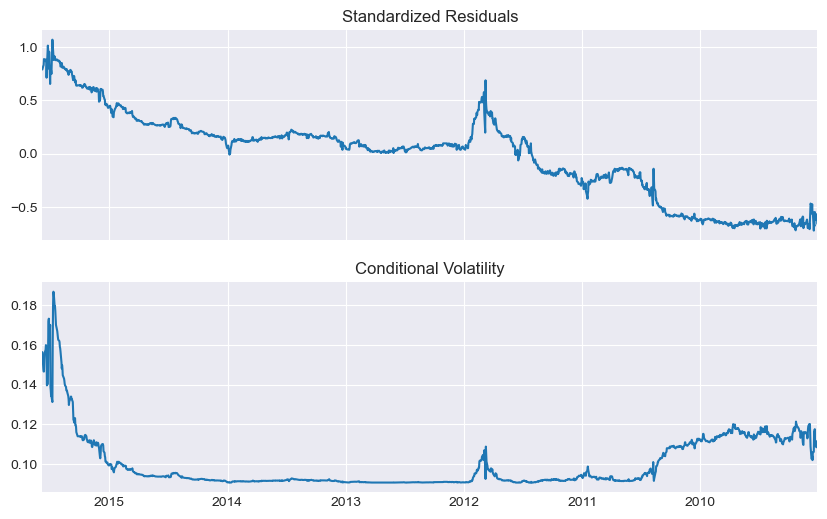

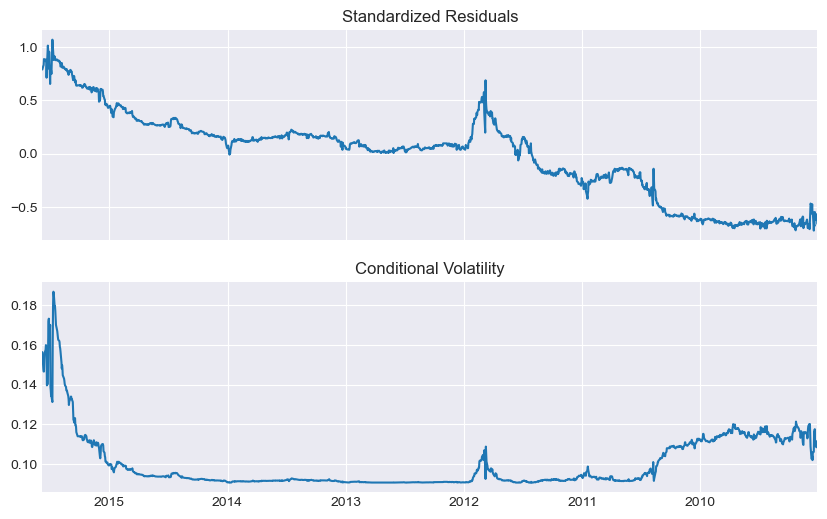

In [23]:
# From tutorial
arch_effect.plot()

### The GARCH Model

#### Results

In [24]:
# GARCH(1,1)
garch_model_11 = arch_model(ex_rate_df['log_TZS/USD'], vol='GARCH', p=1, q=1, rescale=False).fit()
print(garch_model_11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.0441705796654156e+21
Iteration:      2,   Func. Count:     21,   Neg. LLF: 423810643.04768306
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1317.8672484260082
Iteration:      4,   Func. Count:     38,   Neg. LLF: -2693.8896195992475
Iteration:      5,   Func. Count:     43,   Neg. LLF: 5.480865566677022e+20
Iteration:      6,   Func. Count:     58,   Neg. LLF: 78376034104538.52
Iteration:      7,   Func. Count:     73,   Neg. LLF: 83032369.90929835
Iteration:      8,   Func. Count:     83,   Neg. LLF: -615.6848435324962
Iteration:      9,   Func. Count:     88,   Neg. LLF: 56738832.53052183
Iteration:     10,   Func. Count:     94,   Neg. LLF: 1.1356041409195467e+17
Iteration:     11,   Func. Count:    105,   Neg. LLF: 4996551309.173173
Iteration:     12,   Func. Count:    111,   Neg. LLF: 1216611271688199.8
Iteration:     13,   Func. Count:    120,   Neg. LLF: 128902192.51461405
Iteration:     14,   Func. Count:    130, 

#### Diagnostic Checking of the GARCH (1,1) Model
Goodness of fit of the ARCH-GARCH model is based on residuals. The residuals are assumed to be independently and identically distributed following a normal or standardized t-distribution. If the model fits the data well the histogram of the residuals should be approximately symmetric. The ACF and the PACF of the standardized residuals are used for checking the adequacy of the conditional variance model.

##### Normality Test of the Residuals

In [25]:
# Shapiro-Wilk test
sw_test = sw(garch_model_11.resid)
sw_test

ShapiroResult(statistic=0.9240589737892151, pvalue=1.4803198294345835e-28)

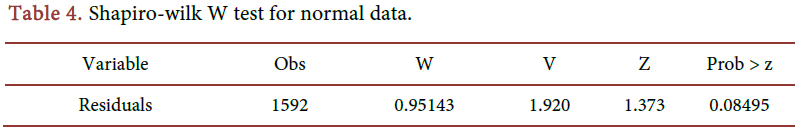

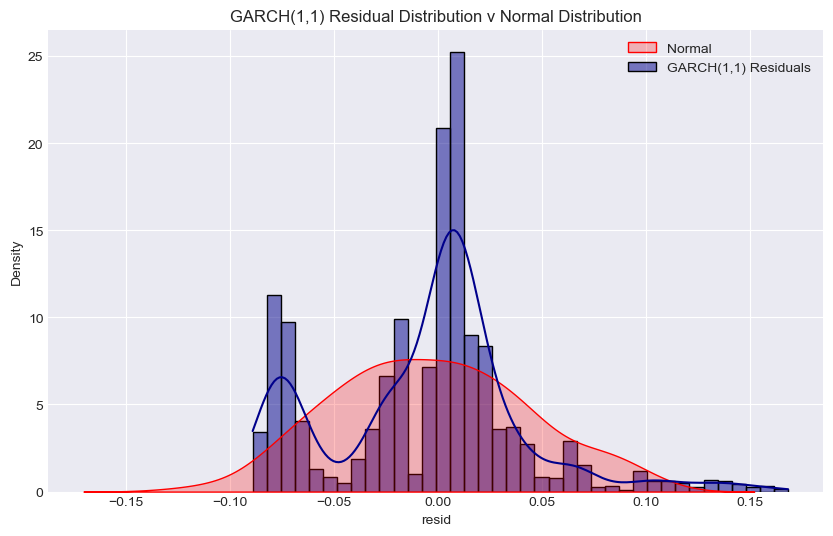

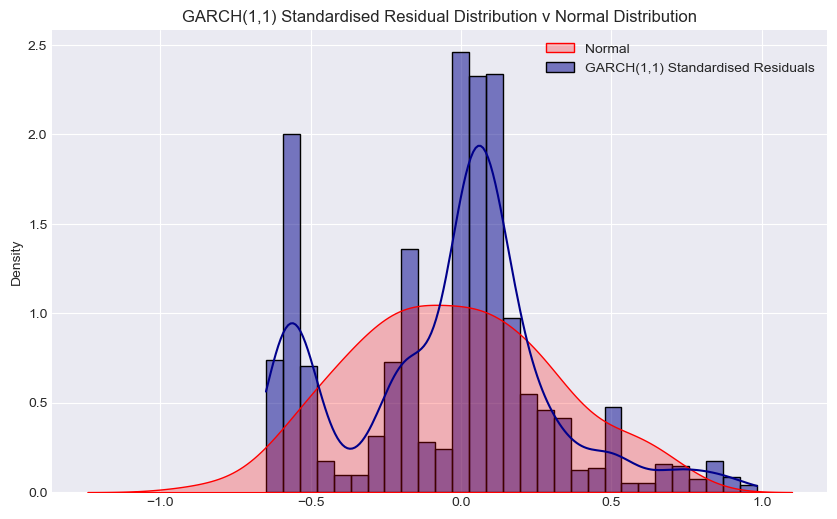

In [26]:
# GARCH (1,1) Residual Distribution v Normal Distribution plot 
plot_series_v_normal(garch_model_11.resid, 'GARCH(1,1) Residuals', 
                     'GARCH(1,1) Residual Distribution v Normal Distribution')

# Tutorial does standardised residuals
garch_model_11_st_resid = np.divide(garch_model_11.resid, garch_model_11.conditional_volatility)

# GARCH (1,1) Standardised Residual Distribution v Normal Distribution plot 
plot_series_v_normal(garch_model_11_st_resid, 'GARCH(1,1) Standardised Residuals', 
                     'GARCH(1,1) Standardised Residual Distribution v Normal Distribution')

In [27]:
# Jarque-Bera (JB) test

jb_test_data = sms.jarque_bera(garch_model_11.resid)
jb_test_df = pd.DataFrame(jb_test_data)
jb_test_df.columns = ['Jarque-Bera']
jb_test_df = jb_test_df.T
jb_test_df.columns = ['Test-Statistic', 'Chi^2 two-tail prob.', 'Skewness', 'Kurtosis']
display(jb_test_df)

,Test-Statistic,Chi^2 two-tail prob.,Skewness,Kurtosis
Jarque-Bera,109.730074,1.487363e-24,0.385603,3.971809


##### Serial Correlation

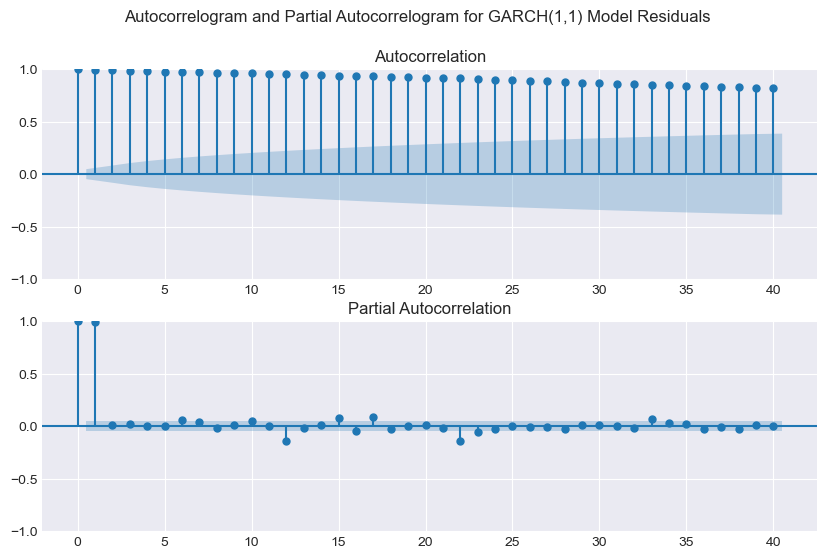

In [28]:
# Partial autocorrelogram and autocorrelogram (with 40 lags) of Residuals plot
plot_acf_pacf(garch_model_11.resid, 'Autocorrelogram and Partial Autocorrelogram for GARCH(1,1) Model Residuals')

In [29]:
# Serial correlation test - Ljung-Box test
LB_test_data = acorr_ljungbox(garch_model_11.resid, lags=40)
LB_test_df = pd.DataFrame.from_records(LB_test_data)
LB_test_df = LB_test_df.rename_axis('Lags') # Rename index
LB_test_df.index = LB_test_df.index + 1 # Set first row to 1 instead of 0
LB_test_df.rename(columns={'lb_stat': 'Q stat','lb_pvalue':'P-Value'},inplace=True) # Rename columns
LB_test_df

,Q stat,P-Value
Lags,,
1,1697.173664,0.0
2,3379.115941,0.0
3,5046.633579,0.0
4,6699.951657,0.0
5,8339.174265,0.0
6,9966.329999,0.0
7,11582.656295,0.0
8,13187.389443,0.0
9,14780.840769,0.0


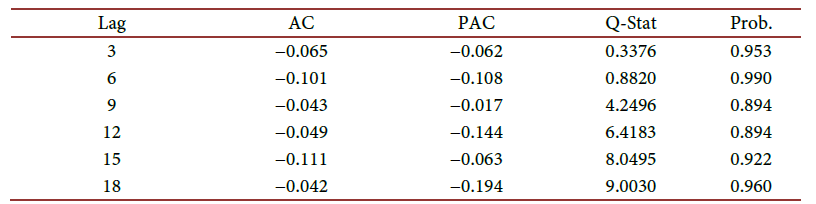

### The Leverage Effects and Asymmetric GARCH

In [30]:
# Exponential GARCH (EGARCH) EGARCH (1,1)
egarch_model_11 = arch_model(ex_rate_df['log_TZS/USD'], vol='EGARCH', p=1, q=1, rescale=False).fit()
print(garch_model_11.summary())

# Why no similar tests to GARCH(1,1) model conducted in the paper?

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.30413084325111e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: 45653555569315.945
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1451270305995.9607
Iteration:      4,   Func. Count:     38,   Neg. LLF: 2399.045453792916
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1826.3297544392613
Iteration:      6,   Func. Count:     48,   Neg. LLF: 3648365.254677823
Iteration:      7,   Func. Count:     54,   Neg. LLF: 1170.1067616148166
Iteration:      8,   Func. Count:     59,   Neg. LLF: 78.29868188404953
Iteration:      9,   Func. Count:     64,   Neg. LLF: -820.7639520596376
Iteration:     10,   Func. Count:     69,   Neg. LLF: 4878.541818958911
Iteration:     11,   Func. Count:     75,   Neg. LLF: 89518284465177.19
Iteration:     12,   Func. Count:     85,   Neg. LLF: 107216.5476082695
Iteration:     13,   Func. Count:     92,   Neg. LLF: -312.2324617796212
Iteration:     14,   Func. Count:     99,   Neg. LLF: -

### Forecasting Evaluation and Accuracy
To measure the forecasting ability, the paper estimates within sample forecasts. The purpose of forecasting within the sample is to test for the predictability power of the model. If the magnitude of the difference between the actual and forecasted values is small then the model has good forecasting power.

(i.e. they do not split data into training and testing)

In [31]:
# Mean absolute error (MAE); the root mean squared error (RMSE); and Theil’s U-statistic

# From Tutorial
# # Splitting data: 2018-01-01
# split_date = pd.datetime(2018,1,1)
# in_sample = sp500.loc[:split_date,'Return']
# out_of_sample = sp500.loc[split_date:,'Return']

# # Model fit by setting the last observation as the split date:
# forecast_fit = arch_model(sp500['Return'], vol='GARCH', p=1, q=1).fit(last_obs=split_date)
# # Multi-step forecast: setting the 'horizon'
# forecasts_garch = forecast_fit.forecast(horizon=len(out_of_sample), start=split_date)
# # Get forecasted variance
# var_forecasted = forecasts_garch.variance[split_date:]

start = pd.datetime(2009,1,5)
actuals = ex_rate_df['log_TZS/USD']
predictions = garch_model_11.forecast(horizon=len(actuals), start=start)
var_predictions = predictions.variance

print(predictions)
var_predictions

# Add predictions

C:\Users\Odhran Murphy\AppData\Local\Temp\ipykernel_3664\1402161208.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2009,1,5)
C:\Users\Odhran Murphy\AppData\Roaming\Python\Python39\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


ValueError: date_index is not monotonic and unique

In [ ]:
# Mean absolute error (MAE); the root mean squared error (RMSE); and Theil’s U-statistic
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

# Theil’s U-statistic - seems to have no library for this test - Calculate manually?
fpe = 
ape = 

U = np.sqrt((np.sum(np.square(fpe-ape))/(np.sum(np.square(ape)))

Theil’s U-statistic
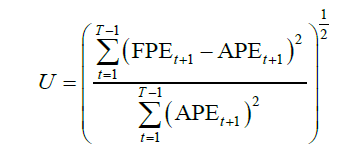
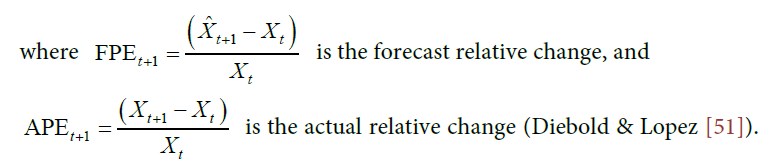

In [ ]:
# Difference between actual and forecasted volatility plot
plot_series(series, 'Accuracy of GARCH(1,1) Model: Log Error (Observation - Forecast)', 
            'Log Error (Observation - Forecast)')

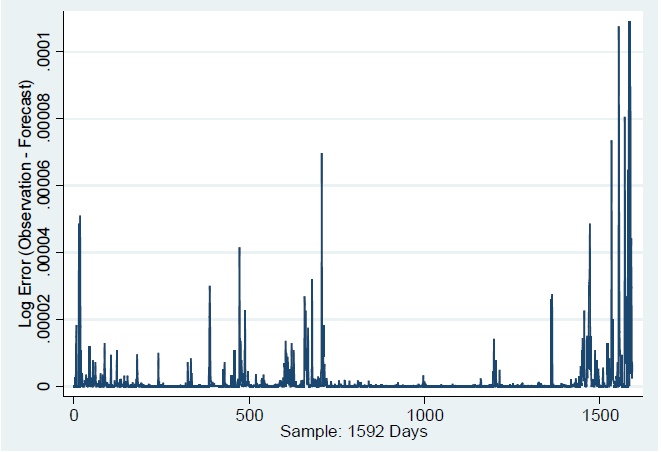